# Tutorial Q2 - Variational quantum eigensolver

This tutorial demonstrates the principle of a variational quantum eigensolver (Peruzzo et al 2014). To showcase the hybrid principle of Penny Lane, we first train a quantum circuit to minimize the squared energy expectation for a Hamiltonian $H$, 

$$ \langle \psi | H | \psi \rangle^2  =( 0.1 \langle \psi_{v} | X_2 | \psi_v \rangle + 0.5 \langle \psi_v | Y_2 | \psi_v \rangle )^2.  $$

Here, $| \psi_v \rangle $ is the state after applying the quantum circuit which depends on trainable variables $v = \{v_1, v_2\}$, and $X_2$, $Y_2$ denote the Pauli-X and Pauli-Y operator acting on the second qubit. *Note: We apply the square to make the optimization landscapes more interesting, but in common applications the cost is the energy expectation directly.*

We then turn things around and use a fixed quantum circuit to prepare $| \psi \rangle $, but train the coefficients of the Hamiltonian to minimize

$$ \langle \psi | H | \psi \rangle^2  = (v_1 \langle \psi | X_2 | \psi \rangle + v_2 \langle \psi | Y_2 | \psi \rangle )^2 . $$


## 1. Optimizing the quantum circuit

### Imports

Alongside the pennylane framework and gradient descent optimizer, we import the original numpy library. 

*Note: If we perform numpy operations in the cost function or any function the cost depends on, we have to use the pennylane version of numpy imported as `from pennylane import numpy as onp`.*

In [1]:
import pennylane as qml
from pennylane.optimize import GradientDescentOptimizer
import numpy as np

We use the default qubit simulator as a device.

In [2]:
dev = qml.device('default.qubit', wires=2)

### Quantum nodes

The quantum circuit of the variational eigensolver is an ansatz that defines a manifold of possible quantum states. We use a Hadamard, two rotations and a CNOT gate. 

In [3]:
def ansatz(var):

    qml.Rot(0.3, 1.8, 5.4, wires=[1])
    qml.RX(var[0], wires=[0])
    qml.RY(var[1], wires=[1])
    qml.CNOT(wires=[0, 1])

A variational eigensolvers requires us to evaluate expectations of different Pauli operators. In this example, the Hamiltonian is expressed by only two single-qubit Pauli operators, namely the X and Y operator applied to the first qubit. 

Since these operators do not commute, we need two quantum nodes, but they can reuse the same device we created. 

*NOTE: If the Pauli observables referred to different qubits, we could use one quantum function and return a tuple of expectations in only one quantum node: `return qml.expectation.PauliX(0), qml.expectation.PauliX(1)`*

In [4]:
@qml.qnode(dev)
def circuit_X(var):
    ansatz(var)
    return qml.expval.PauliX(1)


@qml.qnode(dev)
def circuit_Y(var):
    ansatz(var)
    return qml.expval.PauliY(1)

### Objective

The objective of a VQE, usually called a "cost", is simply a linear combination of the expectations, which defines the expectation of the Hamiltonian we are interested in. 

In [5]:
def cost(var):

    expX = circuit_X(var)
    expY = circuit_Y(var)

    return (0.1*expX + 0.5*expY)**2

This cost defines the following landscape:

*Note: To run the following cell you need the matplotlib library.*

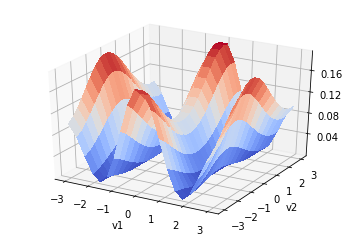

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.linspace(-3., 3., 20)
Y = np.linspace(-3., 3., 20)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[cost([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))

plt.show()

### Optimization

We use the gradient descent optimizer. While the qubit rotation tutorial uses variables as an array, here we decide to write them into a list.

In [7]:
o = GradientDescentOptimizer(0.5)

var = [0.3, 2.5]
var_gd = [var]
for it in range(20):
    var = o.step(cost, var)
    var_gd.append(var)

    print('Cost after step {:5d}: {: .7f} | Variables: [{: .5f},{: .5f}]'
          .format(it+1, cost(var), var[0], var[1]) )

Cost after step     1:  0.1737355 | Variables: [ 0.34699, 2.49206]
Cost after step     2:  0.1675543 | Variables: [ 0.40033, 2.48402]
Cost after step     3:  0.1598003 | Variables: [ 0.46035, 2.47592]
Cost after step     4:  0.1502869 | Variables: [ 0.52718, 2.46780]
Cost after step     5:  0.1389376 | Variables: [ 0.60056, 2.45973]
Cost after step     6:  0.1258558 | Variables: [ 0.67982, 2.45179]
Cost after step     7:  0.1113782 | Variables: [ 0.76374, 2.44405]
Cost after step     8:  0.0960798 | Variables: [ 0.85059, 2.43661]
Cost after step     9:  0.0807058 | Variables: [ 0.93826, 2.42956]
Cost after step    10:  0.0660363 | Variables: [ 1.02448, 2.42297]
Cost after step    11:  0.0527307 | Variables: [ 1.10710, 2.41691]
Cost after step    12:  0.0412146 | Variables: [ 1.18438, 2.41141]
Cost after step    13:  0.0316476 | Variables: [ 1.25514, 2.40648]
Cost after step    14:  0.0239656 | Variables: [ 1.31877, 2.40210]
Cost after step    15:  0.0179609 | Variables: [ 1.37518, 2.39

We can plot the path gradient descent took.

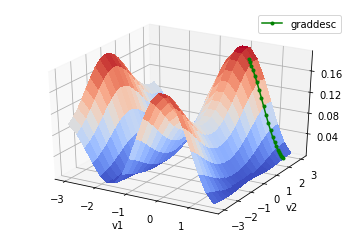

In [8]:
fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.linspace(-3, np.pi/2, 20)
Y = np.linspace(-3, 3, 20)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[cost([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

path_z = [cost(var)+1e-8 for var in var_gd]
path_x = [v[0] for v in var_gd]
path_y = [v[1] for v in var_gd]
ax.plot(path_x, path_y, path_z, c='green', marker='.', label="graddesc")

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))

plt.legend()
plt.show()

## 2. Optimizing the Hamiltonian coefficients

Instead of optimizing the circuit parameters, we can also use a fixed circuit,

In [9]:
def ansatz():

    qml.Rot(0.3, 1.8, 5.4, wires=[1])
    qml.RX(-0.5, wires=[0])
    qml.RY( 0.5, wires=[1])
    qml.CNOT(wires=[0, 1])
    
    
@qml.qnode(dev)
def circuit_X():
    ansatz()
    return qml.expval.PauliX(1)


@qml.qnode(dev)
def circuit_Y():
    ansatz()
    return qml.expval.PauliY(1)

and make the classical coefficients trainable.

In [10]:
def cost(var):

    expX = circuit_X()
    expY = circuit_Y()

    return (var[0]*expX + var[1]*expY)**2

With this cost, ever smaller coefficients decrease the energy expectation.

In [11]:
o = GradientDescentOptimizer(0.5)

var = [0.3, 2.5]
var_gd = [var]
for it in range(20):
    var = o.step(cost, var)
    var_gd.append(var)

    print('Cost after step {:5d}: {: .7f} | Variables: [{: .5f},{: .5f}]'
          .format(it+1, cost(var), var[0], var[1]) )

Cost after step     1:  0.3269168 | Variables: [ 0.95937, 1.49547]
Cost after step     2:  0.0461959 | Variables: [ 1.20723, 1.11786]
Cost after step     3:  0.0065278 | Variables: [ 1.30040, 0.97591]
Cost after step     4:  0.0009224 | Variables: [ 1.33543, 0.92255]
Cost after step     5:  0.0001303 | Variables: [ 1.34859, 0.90250]
Cost after step     6:  0.0000184 | Variables: [ 1.35354, 0.89496]
Cost after step     7:  0.0000026 | Variables: [ 1.35540, 0.89212]
Cost after step     8:  0.0000004 | Variables: [ 1.35610, 0.89106]
Cost after step     9:  0.0000001 | Variables: [ 1.35636, 0.89066]
Cost after step    10:  0.0000000 | Variables: [ 1.35646, 0.89051]
Cost after step    11:  0.0000000 | Variables: [ 1.35650, 0.89045]
Cost after step    12:  0.0000000 | Variables: [ 1.35651, 0.89043]
Cost after step    13:  0.0000000 | Variables: [ 1.35652, 0.89042]
Cost after step    14:  0.0000000 | Variables: [ 1.35652, 0.89042]
Cost after step    15:  0.0000000 | Variables: [ 1.35652, 0.89

Of course, the optimization landscape is nearly linear.

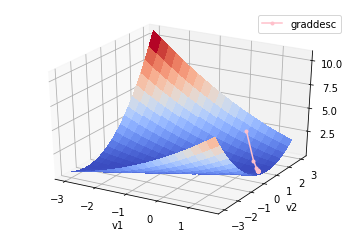

In [12]:
fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.linspace(-3, np.pi/2, 20)
Y = np.linspace(-3, 3, 20)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[cost([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

path_z = [cost(var)+1e-8 for var in var_gd]
path_x = [v[0] for v in var_gd]
path_y = [v[1] for v in var_gd]
ax.plot(path_x, path_y, path_z, c='pink', marker='.', label="graddesc")

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))

plt.legend()
plt.show()

## 3. Optimizing classical and quantum parameters

Of course, we can also optimize "classical" and "quantum" weights together by combining the two approaches from above.

In [13]:
def ansatz(var):

    qml.Rot(0.3, 1.8, 5.4, [1])
    qml.RX(var[0], [0])
    qml.RY(var[1], [1])
    qml.CNOT([0, 1])


@qml.qnode(dev)
def circuit_X(var):
    ansatz(var)
    return qml.expval.PauliX(1)


@qml.qnode(dev)
def circuit_Y(var):
    ansatz(var)
    return qml.expval.PauliY(1)


def cost(var):

    expX = circuit_X(var)
    expY = circuit_Y(var)

    return (var[2]*expX + var[3]*expY)**2


o = GradientDescentOptimizer(0.5)

var = [0.3, 2.5, 0.3, 2.5]

for it in range(10):
    var = o.step(cost, var)
    
    print('Cost after step {:5d}: {: 0.7f}'.format(it+1, cost(var)))


Cost after step     1:  0.1978826
Cost after step     2:  0.0008013
Cost after step     3:  0.0000028
Cost after step     4:  0.0000000
Cost after step     5:  0.0000000
Cost after step     6:  0.0000000
Cost after step     7:  0.0000000
Cost after step     8:  0.0000000
Cost after step     9:  0.0000000
Cost after step    10:  0.0000000
